In [20]:
import numpy as np
from ccdproc import CCDData, combiner
from astropy import units as u
import astropy.io.fits as fits
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.ndimage import shift
import gc
import os
import warnings
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia

from photutils.aperture import ApertureStats

warnings.filterwarnings('ignore')
ROOT_PATH = os.path.normpath(os.getcwd() + os.sep + os.pardir)


In [15]:
# Here's the star class, which includes a name, coordinates, exposure time, airmass, UBVRI fluxes, UBVRI magnitudes.

class Star:
    def __init__(self):
        self.name = "Default name"                                # Object name
        self.filename = "NULL                                  "  # Image file name
        # J2000 coords ra+dec (initially given dummy values)
        self.ra = -99.0
        self.dec = -99.0
        # CCD pixel coords x-y (intially given dummy values)
        self.x = -99.0
        self.y = -99.0
        # UBVRI Fluxes (intially given dummy values)
        self.flux = [-99.0, -99.0, -99.0, -99.0, -99.0]
        # UBRRI Magnitudes (intially given dummy values)
        self.mag = [-99.0, -99.0, -99.0, -99.0, -99.0]
        # G_BP, G and G_RP Magnitudes (intially given dummy values)
        self.gaiamag = [-99.0, -99.0, -99.0]
        self.exptime = 1.0
        self.airmass = 1.0


In [16]:
grgaia = []
f = open("graham_gaia.csv", "r")
grahamtext = f.readlines()
for line in grahamtext:
    currentline = line.split(",")
    if currentline[0] != "Name":
        tstandard = Star()
        tstandard.name = currentline[0]
        tstandard.ra = float(currentline[1])
        tstandard.dec = float(currentline[2])
        tstandard.mag[0] = float(currentline[3])
        tstandard.mag[1] = float(currentline[4])
        tstandard.mag[2] = float(currentline[5])
        tstandard.mag[3] = float(currentline[6])
        tstandard.mag[4] = float(currentline[7])
        tstandard.gaiamag[0] = float(currentline[8])
        tstandard.gaiamag[1] = float(currentline[9])
        tstandard.gaiamag[2] = float(currentline[10])
        grgaia.extend([tstandard])
f.close()


[0.48446054 0.22184931 0.00858087]


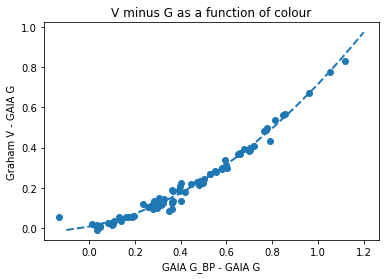

In [17]:
# Plot the difference between V and G as a function of GAIA G_BP and G.

# What is px and py? What is the if statement doing?
px = []
py = []

# here, we initialise empty lists to store our x, y parameter data for each star. Reading a single star's x and y coordinate in the parameter space will add one entry to px and one entry to py - but
# note that this data is order sensitive

for obj in grgaia:
    # Check if we have valid Graham and GAIA magnitudes and colours for the star in question.
    if obj.mag[2] > 0.0 and obj.mag[2] < 20.0 \
        and obj.gaiamag[0] > 0.0 and obj.gaiamag[0] < 20.0 \
        and obj.gaiamag[1] > 0.0 and obj.gaiamag[1] < 20.0 \
            and (obj.mag[2]-obj.gaiamag[1])**2 < 2.25:
        px.append(obj.gaiamag[0]-obj.gaiamag[1])      # G_BP minus G
        py.append(obj.mag[2]-obj.gaiamag[1])          # V minus G

    # Here, we're checking for magnitude data in the if statements. The first ensures that the V band magnitude is between 0 and 20
    # The second ensures that the bp filter magnitude is between 0 and 20
    # The third ensures that the mean magnitude in the g band is between 0 and 20.


# What is this doing?
# Here, we're using np.polyfit to find a polynomial fit of the x and y data. The third argument is 2 to ensure that we fit a degree 2 polynomial (a quadratic).

Vpoly = np.polyfit(px, py, 2)
# Vpoly is a polynomial fit for the V-band
print(Vpoly)

# The format of this is that the equation of the fit is y = Vpoly[0] x^2 + Vpoly[1] x + Vpoly[2]

# What are plx and ply?
# plx is an np array with evenly spaced values between -0.1 and 1.3, with distance in between values of 0.1.as_integer_ratio
# ply is an empty array at first, but we then populate it with the sampled values of the polynomial fit.

# Conceptually, we're creating a pair of x and y arrays corresponding to sampled points on the polynomial fit curve, so that we have points to plot.
plx = np.arange(-0.1, 1.3, 0.1).tolist()
ply = []
for x in plx:
    ply.append(Vpoly[2]+Vpoly[1]*x+Vpoly[0]*x*x)

# What are these lines doing?
plt.title('V minus G as a function of colour')
plt.ylabel('Graham V - GAIA G')
plt.xlabel('GAIA G_BP - GAIA G')
plt.scatter(px, py, marker='o')
plt.plot(plx, ply, linestyle='dashed', linewidth=2)

# Here, we create a plot. The key lines is plt.scatter, which creates a scatter graph from the data, with each dot being a star's x and y value.
# The last line plots the polynomial fit line using the sample data of the points on the polynomial fit.


[0.40048953 0.33460064 0.01283236]


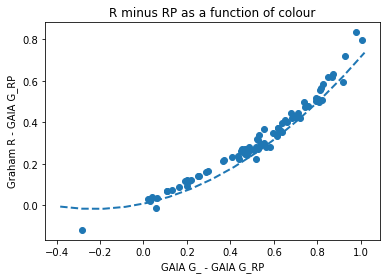

In [18]:
px = []
py = []


for obj in grgaia:
    if obj.mag[2] > 0.0 and obj.mag[2] < 20.0 \
        and obj.gaiamag[0] > 0.0 and obj.gaiamag[0] < 20.0 \
        and obj.gaiamag[1] > 0.0 and obj.gaiamag[1] < 20.0 \
            and (obj.mag[2]-obj.gaiamag[1])**2 < 2.25:
        # G minus G_RP. Here, we've selected the different indices corresponding to the correct filter.
        px.append(obj.gaiamag[1]-obj.gaiamag[2])
        py.append(obj.mag[3]-obj.gaiamag[2])          # Graham R minus G_RP


Rpoly = np.polyfit(px, py, 2)
print(Rpoly)


# Here, I've queried the minimum and maximum values of px in order to produce the domain of our polynomial plot
plx = np.arange(min(px) - 0.1, max(px) + 0.1, 0.1).tolist()
ply = []
for x in plx:
    ply.append(Vpoly[2]+Vpoly[1]*x+Vpoly[0]*x*x)

plt.title('R minus RP as a function of colour')
plt.ylabel('Graham R - GAIA G_RP')
plt.xlabel('GAIA G_ - GAIA G_RP')
plt.scatter(px, py, marker='o')
plt.plot(plx, ply, linestyle='dashed', linewidth=2)

# The bulk of this code is adapted from the cell above, but with care taken to ensure that the indices selected are correct.


In [19]:
gmag = [-99.0, -99.0, -99.0]
# initialise g magnitudes to values unreasonably bright - as a placeholder
coord = SkyCoord(ra=193.49911961463, dec=-60.33542302933,
                 unit=(u.degree, u.degree), frame='icrs')
radius = u.Quantity(0.001, u.deg)
j = Gaia.cone_search_async(coord, radius)
# make the api call
r = j.get_results()
if len(r) > 0:
    gmag[0] = r[0]['phot_bp_mean_mag']
    gmag[1] = r[0]['phot_g_mean_mag']
    gmag[2] = r[0]['phot_rp_mean_mag']
    print(gmag)


INFO: Query finished. [astroquery.utils.tap.core]
[6.847493, 6.68693, 6.4292483]


Here, we've adapted the code from Lab 4 in order to query Gaia data to compute the magnitude in V and R bands for the reference star. We will then use this reference star in order to calculate magnitudes for the other stars in our images.



In [ ]:
bp_minus_g = gmag[0] - gmag[1]
v_minus_g = Vpoly[0]*bp_minus_g**2 + Vpoly[1]*bp_minus_g + Vpoly[2]
v_mag_hd111990 = v_minus_g + gmag[1]
print(v_mag_hd111990)


g_minus_rp = gmag[1] - gmag[2]
r_minus_rp = Rpoly[0]*g_minus_rp**2 + Rpoly[1]*g_minus_rp + Rpoly[2]
r_mag_hd111990 = r_minus_rp + gmag[2]
print(r_mag_hd111990)